In [25]:
from utils import *
from fluxtower_parse import *
from eddy_flux import * 
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows
import os


In [26]:
# Calculate bulk richardson number
#Ri = richardson number
#Rig = gradient richardson number: 
#       provides a measure of the balance between shear and bouyant forces 
#       and the resultant turbulent state of the atmosphere, based on mean 
#       wind and thermodynamic profiles. Negative Rig is an indication of 
#       buoyancy-generated turbulence, positive values are associated with 
#       stably stratified turbulence.
# For simplicity, generally refer to Rig>1 as nonturbulent. 

# Rig = g/T * (dthetaV/dz) / ((du/dz)**2 + (dv/dz)**2)
# thetaV = virtual potential temperature
# T = virtual absolute temperature. 

# Bulk Richardson Number
#hen measuring wind shear and temperature gradients, meteorologists approximate the gradients by measurements at discrete heights:
#This is the form most frequently used. The values of the critical Richardson
#number don’t apply to these finite differences across thick layers. The thinner the
#layer, the closer the value to the theory.

Rb = (g * dthetav * dz) / (thetav * (du**2 + dv**2)) 

# Approximate thetav with theta (potential temperature) for now. 

# Constants
Rd = 287.0 # J/K/kg - gas constant of 1kg of dry air
P0 = 100000.0 # Standard reference pressure, Pa
g = 9.8 # m/s, gravitational acceleration.
cp = 1005.7 # j/kg/K, assuming dry air at 273K

# Difference between M1 and M2
dz = 11.3 # m


In [27]:
# We need: 
# M1, winds and T
# M2, winds and T 
# Pressure value - from licor

# Input processed data location
d_loc = '/Volumes/Data/ICECAPSarchive/fluxtower/processed/'

# Output location
out_loc = '/Users/heather/ICECAPS-ACE/Processed/'

# Start and stop date:
start = dt.datetime(2019,8,20,0,0)
stop = dt.datetime(2019,8,21,0,0)

# Days to loop through
days = pd.date_range(start,stop,freq='1D')

## Start loop ##
#for day in days:
day = days[0]
day_str = str(day.date()) 
print(day_str)
    
# Get metek data
if os.path.isfile(d_loc+'metek/metek1_%s'%day_str):
    m1_orig = pd.read_csv(d_loc+'metek/metek1_%s'%day_str, index_col=0, parse_dates=[0])
    if m1_orig.empty:
        print('Error: File empty, '+day_str)
else:
    print('Error: File empty, '+day_str)
    
if os.path.isfile(d_loc+'metek/metek2_%s'%day_str):
    m2_orig = pd.read_csv(d_loc+'metek/metek2_%s'%day_str, index_col=0, parse_dates=[0])
    if m2_orig.empty:
        print('Error: File empty, '+day_str)
else:
    print('Error: File empty, '+day_str)


# Clean metek data 
m1 = clean_metek(m1_orig)
m2 = clean_metek(m2_orig)

# Cross-wind temperature correction
m1['T'] = Ts_sidewind_correction(m1['T'].astype(float),m1['x'].astype(float),m1['y'].astype(float),m1['z'].astype(float))
m2['T'] = Ts_sidewind_correction(m2['T'].astype(float),m2['x'].astype(float),m2['y'].astype(float),m2['z'].astype(float))


2019-08-20


In [46]:
# Get pressure from licor
# Get licor data
if os.path.isfile(d_loc+'LiCOR/licor_%s'%day_str):
    licor = pd.read_csv(d_loc+'LiCOR/licor_%s'%day_str, index_col=0, parse_dates=[0])
else:
    print('Error: File empty, '+day_str)

P = licor['P']
# Average p onto the same time and join
P = P.resample('100L').mean().interpolate(method='time') # Interpolate over licor gaps in pressure
m1['P']=P
m2['P']=P
m2['P']=m2['P'].fillna(method='bfill')
m1['P']=m1['P'].fillna(method='bfill')

In [47]:
# theta = T(P0/P)**(Rd/cp)
# Assume that m1 and m2 are more or less the same pressure. 
m1_theta = m1['T'] * (P0/m1['P']) ** (Rd/cp)
m2_theta = m2['T'] * (P0/m2['P']) ** (Rd/cp)

In [48]:
dtheta = m2_theta - m1_theta
du = m2['x'] - m1['x']
dv = m2['y'] - m1['y']

In [57]:
# Rig = g/T * (dthetaV/dz) / ((du/dz)**2 + (dv/dz)**2)

#Rig = ((g/m1['T']) * ((dtheta/dz)) / (((du/dz)**2) + ((dv/dz)**2)))
Rb = (g * dtheta * dz) / (m1_theta * (du**2 + dv**2)) 

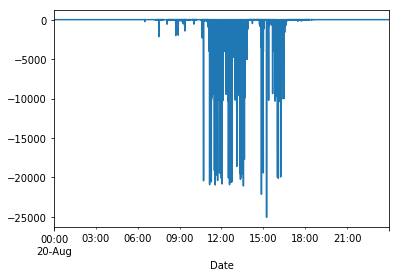

In [63]:
Rb.plot()

In [59]:
np.nanmax(Rb)

0.10129257429053538

In [60]:
np.nanmin(Rb)

-inf

In [62]:
du**2 + dv**2

Date
2019-08-20 00:00:00.000     9.1925
2019-08-20 00:00:00.100     8.8562
2019-08-20 00:00:00.200     9.5729
2019-08-20 00:00:00.300     9.6260
2019-08-20 00:00:00.400     9.0746
2019-08-20 00:00:00.500     9.7585
2019-08-20 00:00:00.600    10.0825
2019-08-20 00:00:00.700     9.8501
2019-08-20 00:00:00.800     9.4445
2019-08-20 00:00:00.900     8.7365
2019-08-20 00:00:01.000     9.0913
2019-08-20 00:00:01.100     9.3029
2019-08-20 00:00:01.200     8.8450
2019-08-20 00:00:01.300     9.4113
2019-08-20 00:00:01.400     9.3965
2019-08-20 00:00:01.500     9.3850
2019-08-20 00:00:01.600     9.9749
2019-08-20 00:00:01.700    10.3121
2019-08-20 00:00:01.800    10.0861
2019-08-20 00:00:01.900     9.8216
2019-08-20 00:00:02.000     9.4916
2019-08-20 00:00:02.100     9.6245
2019-08-20 00:00:02.200     9.7928
2019-08-20 00:00:02.300     9.8960
2019-08-20 00:00:02.400     9.9874
2019-08-20 00:00:02.500    10.1345
2019-08-20 00:00:02.600     9.4225
2019-08-20 00:00:02.700     9.7732
2019-08-20 00:0